# Work on PAIN condition patients

In [1]:
# warnings.filterwarnings("ignore")
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.util.testing import assert_frame_equal
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns",200)

import tensorflow as tf
from tensorflow import keras
from sklearn.utils import resample
from sklearn.metrics import recall_score

from keras.utils import to_categorical
from sklearn.utils import compute_class_weight


# tf.disable_eager_execution()
# tf.enable_eager_execution()

from sklearn.preprocessing import StandardScaler

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

/home/crkellar@byu.local/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/crkellar@byu.local/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/crkellar@byu.local/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/crkellar@byu.local/.local/lib/python3.6/site-pack

TensorFlow version: 1.14.0
Eager execution: False


/home/crkellar@byu.local/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/crkellar@byu.local/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/crkellar@byu.local/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/crkellar@byu.local/.local/li

In [2]:
#make a chronic patient table for this subset of conditions

# read in that pre-made table
df=pd.read_csv("../data_files/chronic_patients.csv")
df = df.dropna(axis = 0,how='any')
upsample=False

Brute force (but with upsampling) -  try to just make a test/train split, and run a NN on it

In [3]:
X = df[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'PAYTYPE','YEAR','PATWT', 'chronic','pain']]
y = df[['received']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

train = pd.concat([X_train, y_train], axis=1, sort=False)

In [4]:
#upsample the opiate-receivers
df_maj = train[train.received==0]
df_min = train[train.received==1]

if upsample:
    df_minority_upsampled = resample(df_min, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_maj))    # to match majority class
                                     #random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    train = pd.concat([df_maj, df_minority_upsampled])
else: #downsample
    df_majority_downsampled = resample(df_maj, 
                                     replace=False,     # sample with replacement
                                     n_samples=len(df_min))    # to match majority class
                                     #random_state=123) # reproducible results
    # Combine minority class with downsampled majority class
    train = pd.concat([df_majority_downsampled, df_min])

 
# Display new class counts
train.received.value_counts()

1    13524
0    13524
Name: received, dtype: int64

In [5]:
#upsample the pain-diagnosed
df_maj = train[train.pain==0]
df_min = train[train.pain==1]
df_minority_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_maj),    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
train = pd.concat([df_maj, df_minority_upsampled])
 
# Display new class counts
train.pain.value_counts()

1    23823
0    23823
Name: pain, dtype: int64

In [6]:
X_train = train[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'PAYTYPE','YEAR','PATWT', 'chronic','pain']]
y_train = train[['received']]

In [7]:
#get the sample weights for the training data, remove the patwt col from other sets
sample_weights = X_train.PATWT.ravel()
#diagnoses, rfv's, and meds are poorly encoded for this, as they're numerical representations of categorical data
#removed: , 'RFV1', 'DIAG1', 'DIAG2', 'DIAG3', 'DIAG4', 'DIAG5', 'MED1'
X_train = X_train[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'PAYTYPE','YEAR', 'chronic','pain']]
X_test = X_test[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'PAYTYPE','YEAR', 'chronic','pain']]
print(X_train.shape)
print(sample_weights.shape)
#print(X_val.shape)

(47646, 9)
(47646,)


In [8]:
# Normalize the data
scaler = StandardScaler()
print("firsst", np.max(X_train))
X_train = scaler.fit_transform(X_train)

#X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("second",np.max(X_train))

firsst VMONTH       12.0
AGE         100.0
SEX           2.0
RACE          6.0
ETHNIC        3.0
PAYTYPE       9.0
YEAR       2016.0
chronic       1.0
pain          1.0
dtype: float64
second 7.704008085535389


In [13]:
# build the model

model = keras.models.Sequential()  # simplest model: a stack of layers
model.add(keras.layers.Dense(32, input_dim=9)) # just flatten (num cols)
model.add(keras.layers.Dense(30, activation="relu")) # Dense layer
model.add(keras.layers.Dense(1, activation="softmax")) # Dense layer
                                   # with 2 outputs, using
                                   # softmax because this is 
                                   # a logistic classification

In [14]:
# model.summary()

In [15]:
# Compile the model 
learning_rate=0.1
decay = 1e-6
model.compile(loss="binary_crossentropy",
              #optimizer='adam',
              optimizer=keras.optimizers.SGD(lr = learning_rate,
                                             decay = decay,
                                             momentum = 0.9, 
                                             nesterov=False),
             metrics=["accuracy"])

## use sparse because categorical labels => sparse one-hot encoding

In [16]:
# Train the model
history = model.fit(np.array(X_train), np.array(y_train), 
                    epochs=15,
                    validation_split=.1,
                   # validation_data=(np.array(X_val), np.array(y_val),val_weights),
                    sample_weight = sample_weights)
# batch_size defaults to 32

Train on 42881 samples, validate on 4765 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
42881/42881 [==============================] - 1s 27us/sample - loss: 169517.1783 - acc: 0.5969 - val_loss: 93912.1012 - val_acc: 0.7706
Epoch 2/15
42881/42881 [==============================] - 1s 24us/sample - loss: 169517.1781 - acc: 0.5969 - val_loss: 93912.1006 - val_acc: 0.7706
Epoch 3/15
42881/42881 [==============================] - 1s 24us/sample - loss: 169517.1785 - acc: 0.5969 - val_loss: 93912.1008 - val_acc: 0.7706
Epoch 4/15
42881/42881 [==============================] - 1s 24us/sample - loss: 169517.1787 - acc: 0.5969 - val_loss: 93912.0997 - val_acc: 0.7706
Epoch 5/15
42881/42881 [==============================] - 1s 24us/sample - loss: 169517.1787 - acc: 0.5969 - val_loss: 93912.1006 - val_acc: 0.7706
Epoch 6/15
42881/42881 [==============================] - 1s 24us/sample - loss: 169517.1783 - acc: 0.5969 - val_loss

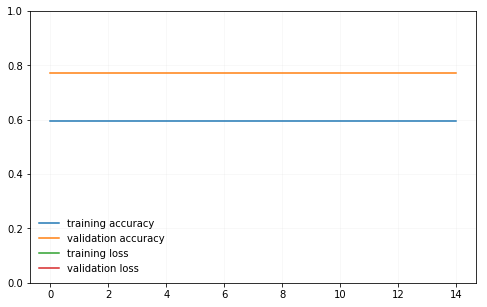

In [19]:
# Plot the history
plt.figure(figsize=(8,5))
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(frameon=False)
plt.grid(True, alpha=0.1)
plt.ylim(0,1);

In [18]:
## Finally, evaluate on the actual test set.
model.evaluate(X_test, y_test)

118183/118183 [==============================] - 1s 10us/sample - loss: 14.7494 - acc: 0.0381


[14.74940183262085, 0.038076542]